# Transcription factor activity inference

scRNA-seq yield many molecular readouts that are hard to interpret by themselves. One way of summarizing this information is by infering transcription factor (TF) activities from prior knowledge.

In this notebook we showcase how to use `decoupler` for TF activity inference with the 3k PBMCs 10X data-set. The data consists of 3k PBMCs from a Healthy Donor and is freely available
from 10x Genomics [here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)
from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the [Usage](https://decoupler-py.readthedocs.io/en/latest/notebooks/usage.html) tutorial first.

</div>

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

In [1]:
import scanpy as sc
import decoupler as dc

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

## Loading the data

We can download the data easily using `scanpy`:

In [2]:
adata = sc.datasets.pbmc3k_processed()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can visualize the different cell types in it:

/home/badi/miniconda3/envs/dcp39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


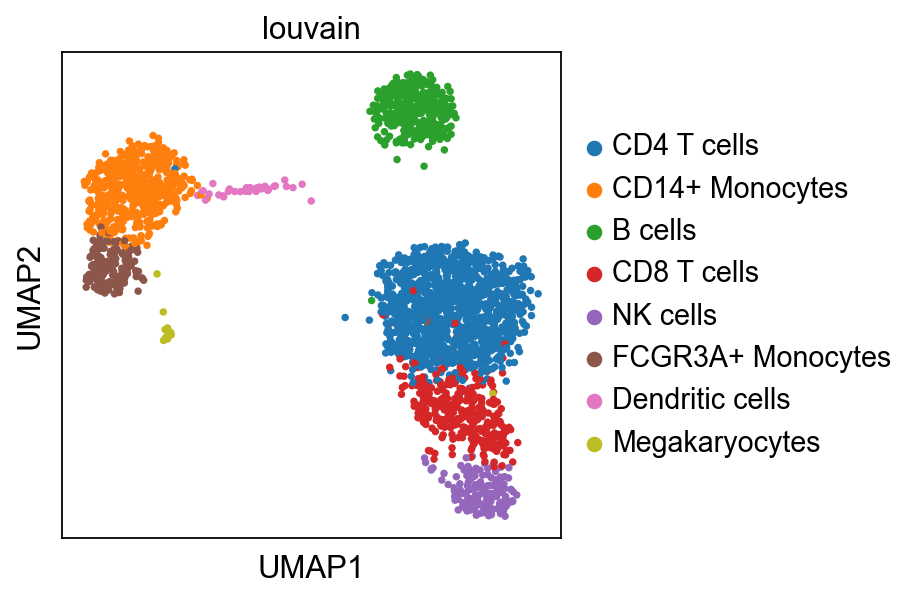

In [3]:
sc.pl.umap(adata, color='louvain')

## CollecTRI network
[CollecTRI](https://github.com/saezlab/CollecTRI) is a comprehensive resource
containing a curated collection of TFs and their transcriptional targets
compiled from 12 different resources. This collection provides an increased
coverage of transcription factors and a superior performance in identifying
perturbed TFs compared to our previous
[DoRothEA](https://saezlab.github.io/dorothea/) network and other literature
based GRNs. Similar to DoRothEA, interactions are weighted by their mode of
regulation (activation or inhibition).

For this example we will use the human version (mouse and rat are also
available). We can use `decoupler` to retrieve it from `omnipath`. The argument
`split_complexes` keeps complexes or splits them into subunits, by default we
recommend to keep complexes together.

In [4]:
net = dc.get_collectri(organism='human', split_complexes=False)
net

,source,target,weight
0,MYC,TERT,1
1,SPI1,BGLAP,1
2,SMAD3,JUN,1
3,SMAD4,JUN,1
4,STAT5A,IL2,1
...,...,...,...
43173,NFKB,hsa-miR-143-3p,1
43174,AP1,hsa-miR-206,1
43175,NFKB,hsa-miR-21-5p,1
43176,NFKB,hsa-miR-224-5p,1


<div class="alert alert-info">

**Note**
    
In this tutorial we use the network CollecTRI, but we could use any other GRN coming from an inference method such as [CellOracle](https://morris-lab.github.io/CellOracle.documentation/), [pySCENIC](https://pyscenic.readthedocs.io/en/latest/) or [SCENIC+](https://scenicplus.readthedocs.io/en/latest/). 

</div> 

## Activity inference with univariate linear model (ULM)

To infer TF enrichment scores we will run the univariate linear model (`ulm`) method. For each cell in our dataset (`adata`) and each TF in our network (`net`), it fits a linear model that predicts the observed gene expression
based solely on the TF's TF-Gene interaction weights. Once fitted, the obtained t-value of the slope is the score. If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.

<img src="../ulm.png"
     width="800" 
     height="auto" />

To run `decoupler` methods, we need an input matrix (`mat`), an input prior knowledge
network/resource (`net`), and the name of the columns of `net` that we want to use.

In [5]:
dc.run_ulm(
    mat=adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

1 features of mat are empty, they will be removed.
Running ulm on mat with 2638 samples and 13713 targets for 607 sources.


The obtained scores (`ulm_estimate`) and p-values (`ulm_pvals`) are stored in the `.obsm` key:

In [6]:
adata.obsm['ulm_estimate']

,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID1A,ARID1B,ARID3A,ARID3B,...,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91,ZXDC
AAACATACAACCAC-1,3.105108,0.879530,2.797346,3.422538,0.822490,2.255497,0.622142,-0.454221,-0.497593,-0.454221,...,0.051974,-3.070459,-0.287242,-0.454221,-0.485021,1.168157,0.816603,-0.454221,1.418368,2.328569
AAACATTGAGCTAC-1,0.644295,-0.912085,0.847559,2.283962,0.947832,1.649844,-0.594861,-0.594861,-0.651663,-0.594861,...,-0.334588,0.798214,0.266102,0.217661,0.651663,0.263393,1.700019,-0.594861,1.987362,0.692963
AAACATTGATCAGC-1,2.105177,2.411171,2.377469,5.492645,2.126639,3.829876,-0.566934,-0.566934,-0.621069,0.393625,...,-0.841095,-5.552065,0.400783,0.393625,0.621069,0.214635,-0.206980,0.955540,1.550988,0.393625
AAACCGTGCTTCCG-1,0.276419,-0.050775,3.569541,3.078989,2.169047,4.214092,-0.523795,-0.523795,-0.573810,-0.523795,...,2.882545,-0.057148,-0.331239,-0.523795,-0.356888,-0.639188,0.739293,-0.523795,3.618458,2.535251
AAACCGTGTATGCG-1,2.003545,-0.067341,2.771824,3.891622,2.185179,1.854872,-0.393707,1.259176,-0.431300,-0.393707,...,1.182521,0.528292,1.057586,2.912812,0.431300,-2.207975,-0.143738,-0.393707,2.645360,-0.393707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,2.285926,1.772497,3.652293,3.996353,1.279147,4.544248,0.336528,-0.569493,0.203239,0.336528,...,1.184780,-2.550562,-0.360137,-0.569493,0.623872,-0.154076,-0.207914,0.336528,3.200953,1.534341
TTTCTACTGAGGCA-1,2.273949,0.702123,1.068236,2.516975,0.813740,3.195337,0.318471,-0.589067,0.183182,0.318471,...,0.350074,-1.457080,-0.372515,-0.589067,0.645316,0.807655,-0.215061,0.318471,2.851227,1.226067
TTTCTACTTCCTCG-1,2.906379,1.537122,2.872457,2.581656,0.765484,1.361253,-0.415449,-0.415449,-0.455119,-0.415449,...,-0.616350,-2.878302,-0.262723,-0.415449,0.455119,0.583217,-0.151676,-0.415449,1.564088,-0.415449
TTTGCATGAGAGGC-1,-0.308190,0.795886,2.723709,3.794402,3.330887,0.986236,-0.363224,-0.363224,-0.397907,-0.363224,...,0.543889,0.487389,-0.229697,-0.363224,0.397907,0.308464,-0.132609,-0.363224,3.485425,1.242469


**Note**: Each run of `run_ulm` overwrites what is inside of `ulm_estimate` and `ulm_pvals`. if you want to run `ulm` with other resources and still keep the activities inside the same `AnnData` object, you can store the results in any other key in `.obsm` with different names, for example:

In [7]:
adata.obsm['collectri_ulm_estimate'] = adata.obsm['ulm_estimate'].copy()
adata.obsm['collectri_ulm_pvals'] = adata.obsm['ulm_pvals'].copy()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'ulm_estimate', 'ulm_pvals', 'collectri_ulm_estimate', 'collectri_ulm_pvals'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Visualization

To visualize the obtained scores, we can re-use many of `scanpy`'s plotting functions.
First though, we need to extract them from the `adata` object.

In [8]:
acts = dc.get_acts(adata, obsm_key='ulm_estimate')

# We can scale the obtained activities for better visualizations
sc.pp.scale(acts)
acts

AnnData object with n_obs × n_vars = 2638 × 607
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'mean', 'std'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'ulm_estimate', 'ulm_pvals', 'collectri_ulm_estimate', 'collectri_ulm_pvals'

`dc.get_acts` returns a new `AnnData` object which holds the obtained activities in its `.X` attribute, allowing us to re-use many `scanpy` functions, for example:

/home/badi/miniconda3/envs/dcp39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


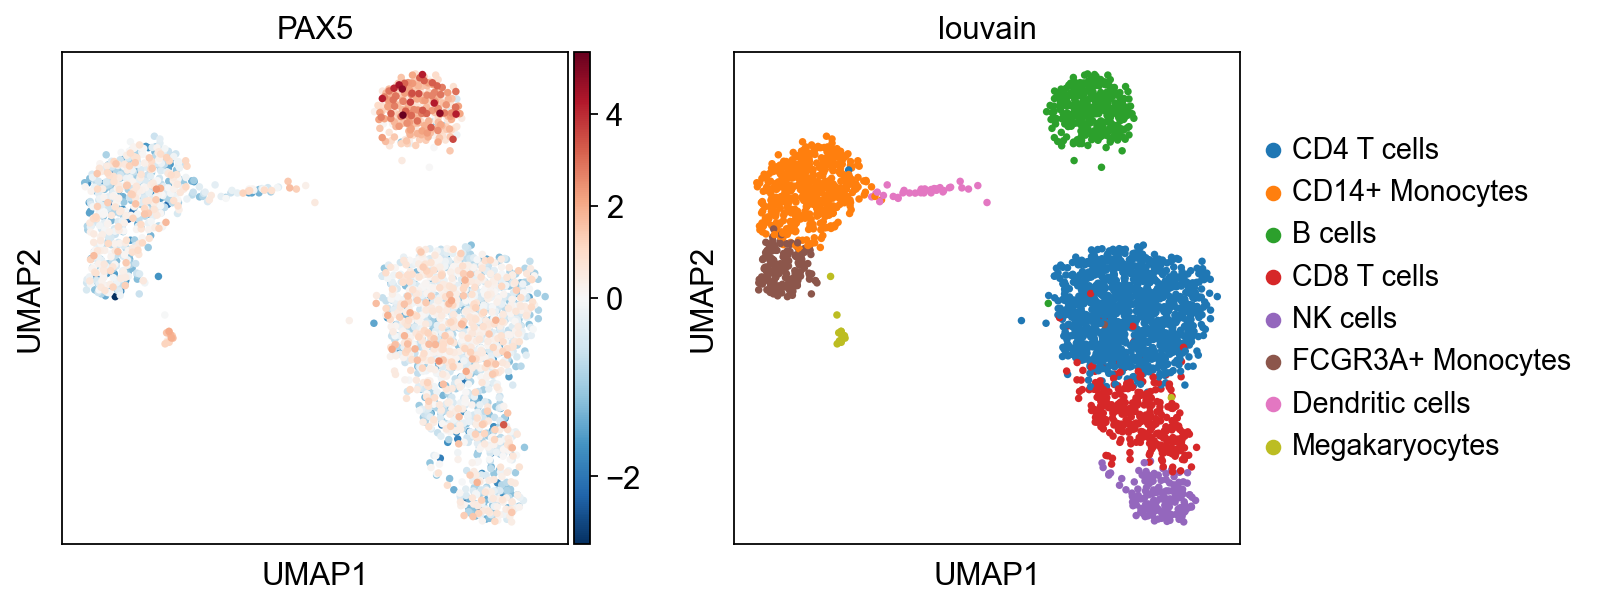

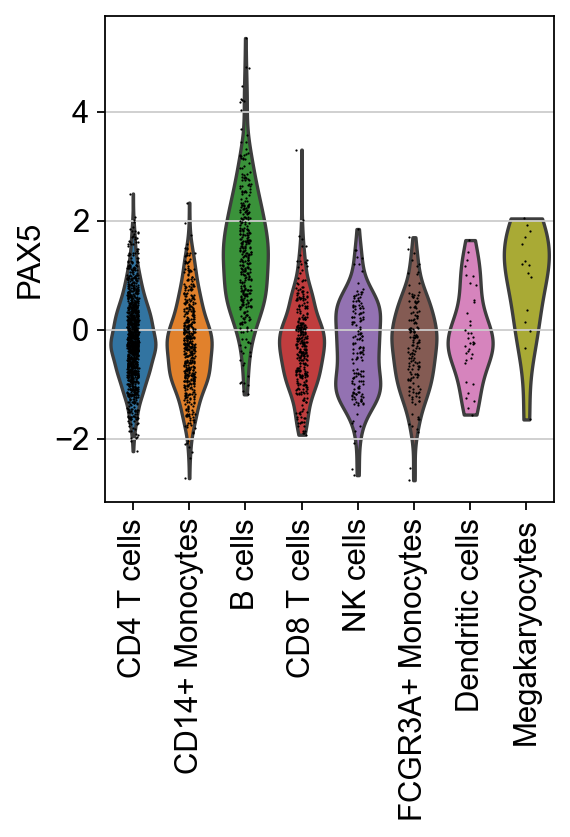

In [9]:
sc.pl.umap(acts, color=['PAX5', 'louvain'], cmap='RdBu_r', vcenter=0)
sc.pl.violin(acts, keys=['PAX5'], groupby='louvain', rotation=90)

Here we observe the activity infered for PAX5 across cells, which it is particulary active in B cells. Interestingly, PAX5 is a known TF crucial for B cell identity and function.
The inference of activities from "foot-prints" of target genes is more informative than just looking at the molecular readouts of a given TF, as an example here is the gene expression of PAX5, which is not very informative by itself since it is just expressed in few cells:

/home/badi/miniconda3/envs/dcp39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


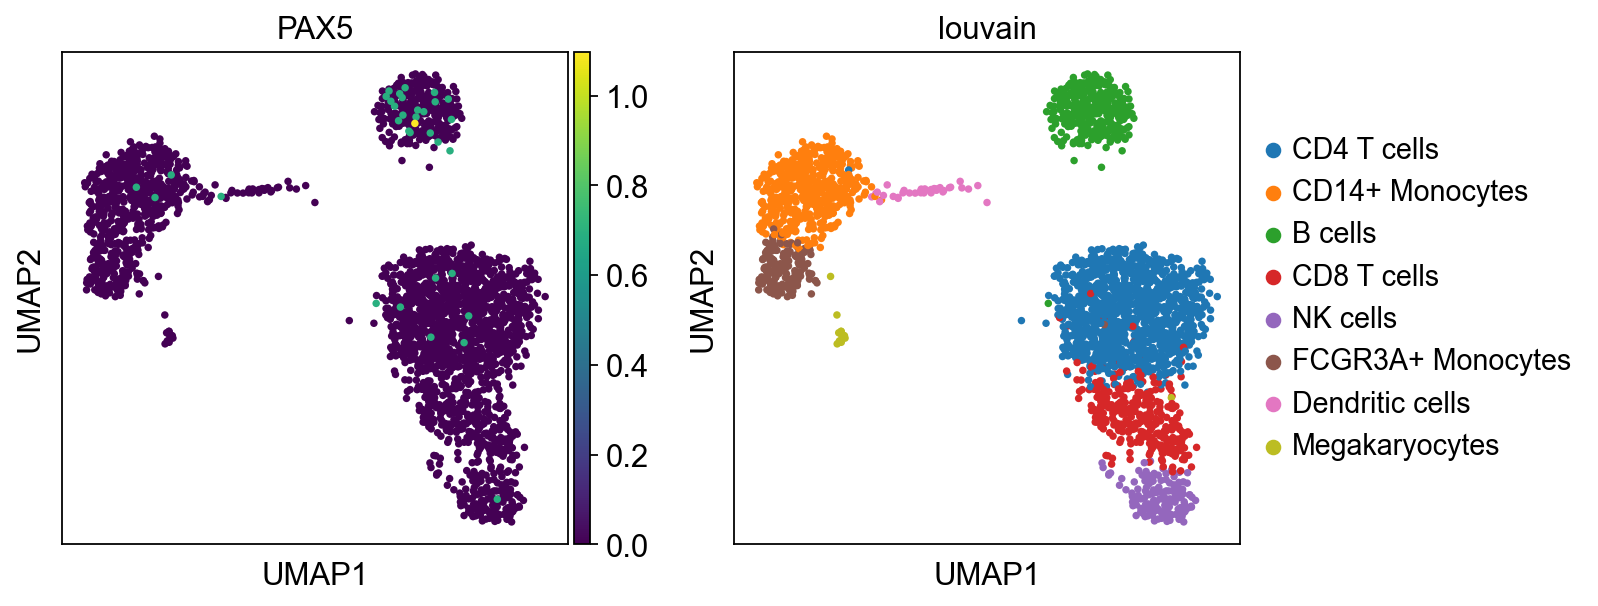

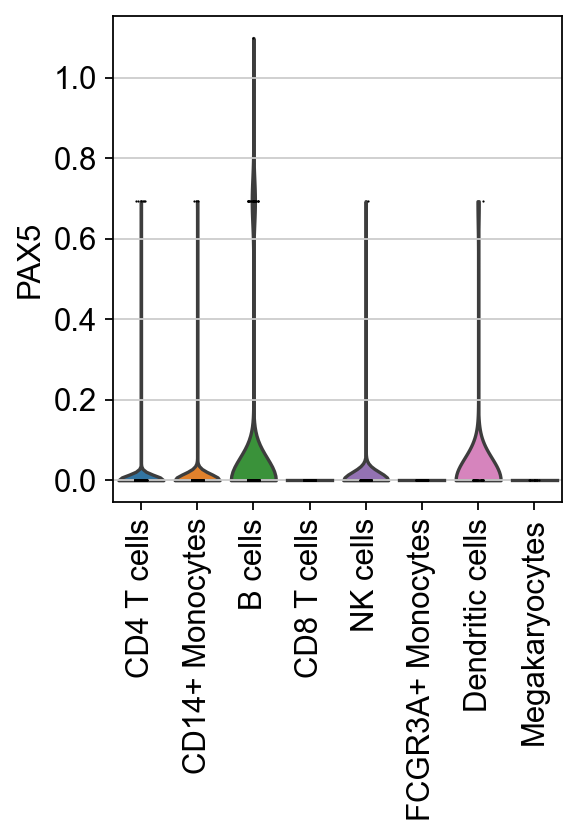

In [10]:
sc.pl.umap(adata, color=['PAX5', 'louvain'])
sc.pl.violin(adata, keys=['PAX5'], groupby='louvain', rotation=90)

## Exploration

Let's identify which are the top TF per cell type. We can do it by using the function `dc.rank_sources_groups`, which identifies marker TFs using the same statistical tests available in scanpy's `scanpy.tl.rank_genes_groups`.

In [11]:
df = dc.rank_sources_groups(acts, groupby='louvain', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,B cells,rest,EBF1,46.169396,2.537258,7.629479e-180,1.157773e-177
1,B cells,rest,RFXANK,41.651299,2.107043,1.120716e-186,6.802747e-184
2,B cells,rest,RFXAP,41.465613,2.098666,1.993151e-185,4.032808e-183
3,B cells,rest,RFX5,41.407092,2.103163,1.183196e-185,3.591001e-183
4,B cells,rest,CIITA,38.505334,2.065852,7.573948e-173,9.194773e-171
...,...,...,...,...,...,...,...
4851,NK cells,rest,HMGA2,-11.360249,-1.144674,5.056413e-25,1.705135e-23
4852,NK cells,rest,MYC,-11.529474,-1.129109,1.887027e-25,7.158910e-24
4853,NK cells,rest,THRA,-11.795940,-1.152464,2.314757e-26,9.367050e-25
4854,NK cells,rest,TCF4,-11.821817,-1.241153,8.805332e-27,3.817740e-25


We can then extract the top 3 markers per cell type:

In [12]:
n_markers = 3
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

{'B cells': ['EBF1', 'RFXANK', 'RFXAP'],
 'CD14+ Monocytes': ['ONECUT1', 'EHF', 'ELF3'],
 'CD4 T cells': ['DNMT3A', 'MYC', 'MBD2'],
 'CD8 T cells': ['KLF13', 'NFKB2', 'RELB'],
 'Dendritic cells': ['RFXAP', 'RFXANK', 'RFX5'],
 'FCGR3A+ Monocytes': ['SIN3A', 'PPARD', 'SPIC'],
 'Megakaryocytes': ['PKNOX1', 'PBX2', 'FLI1'],
 'NK cells': ['ZGLP1', 'CEBPZ', 'ZNF395']}

We can plot the obtained markers:

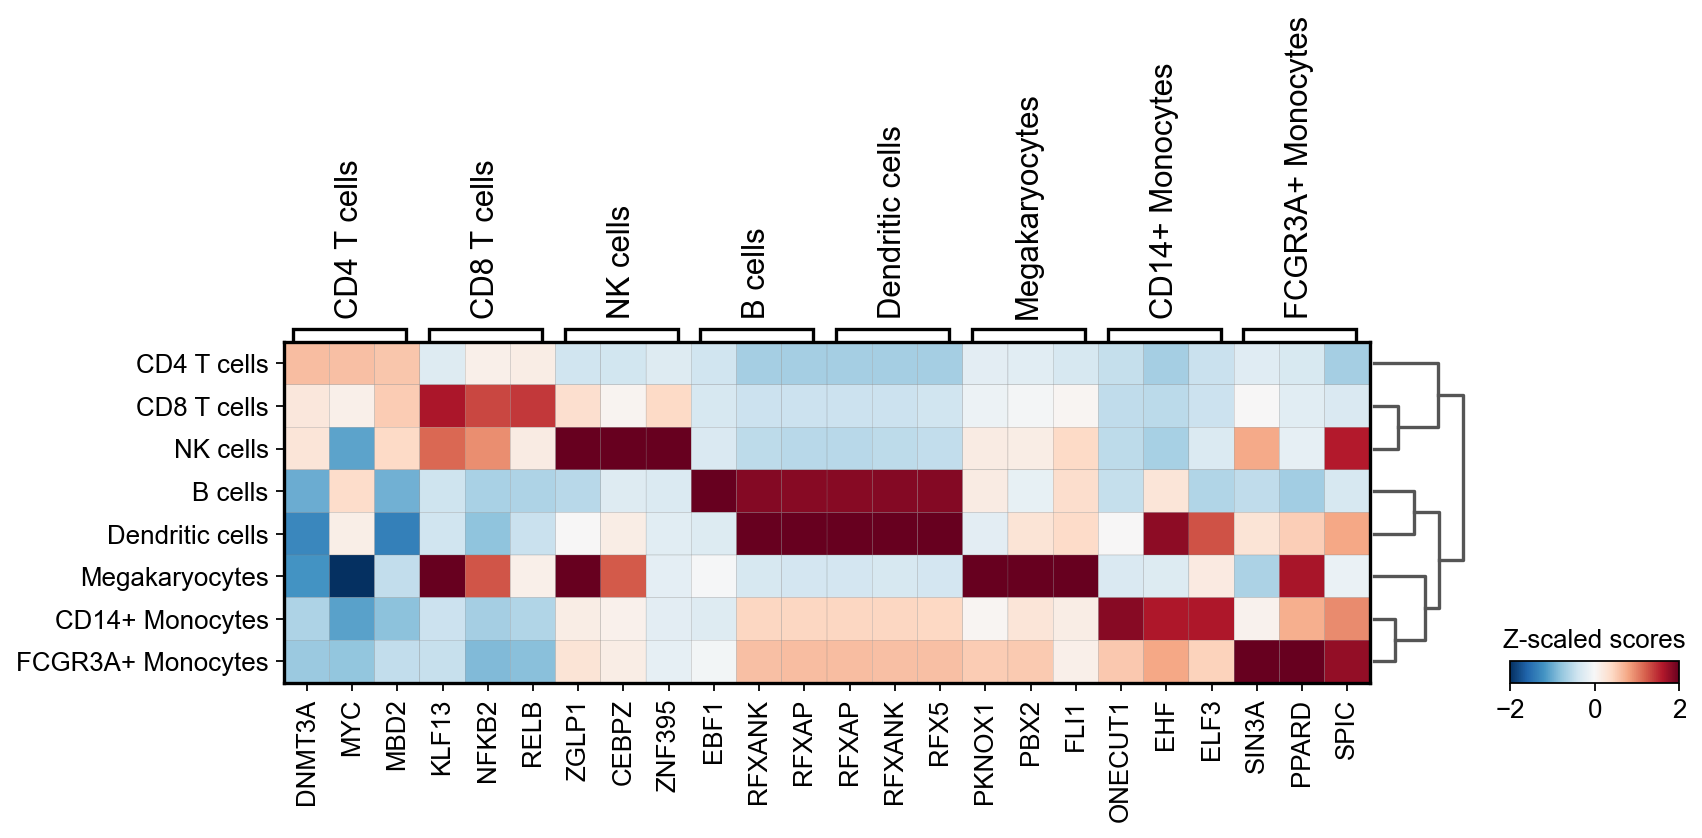

In [13]:
sc.pl.matrixplot(acts, source_markers, 'louvain', dendrogram=True,
                 colorbar_title='Z-scaled scores', vmin=-2, vmax=2, cmap='RdBu_r')

Finally, we can check individual TFs by plotting their distributions:

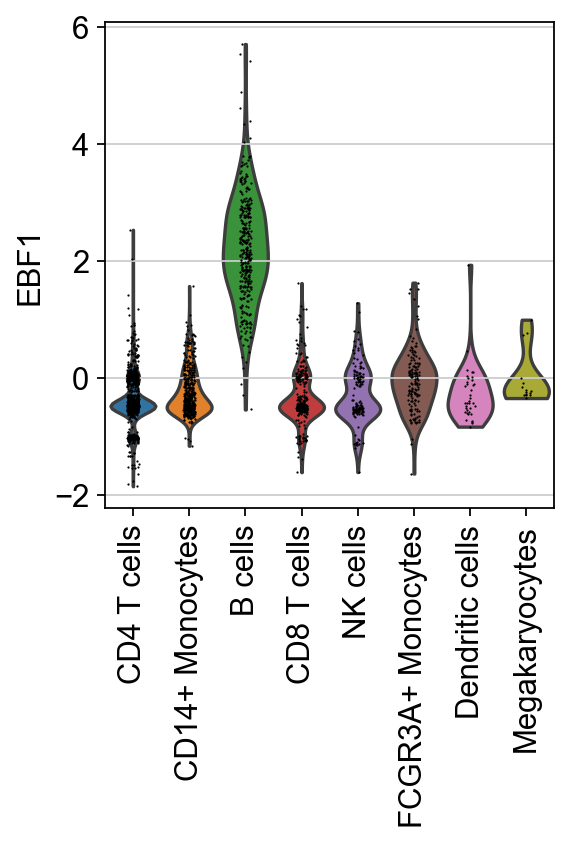

In [14]:
sc.pl.violin(acts, keys=['EBF1'], groupby='louvain', rotation=90)

Here we can observe the TF activities for EBF1, which is a known marker TF for B cells. 

<div class="alert alert-info">

**Note**
    
If your data consist of different conditions with enough samples, we recommend to work with pseudo-bulk profiles instead. Check this
[vignette](https://decoupler-py.readthedocs.io/en/latest/notebooks/pseudobulk.html) for more informatin.

</div>